# 시즌별의 EDA
- 각 시즌 인기: s1_avg_rating, s1_avg_views, 's1_retention_rate'
- 각 시즌 특징: runtime, genre, age_rating, production_country, 'term'

## import

In [1]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import plotly.graph_objects as go
from matplotlib import font_manager,rc

get_ipython().run_line_magic('matplotlib','inline')
# %matplotlib inline

path = 'C:/Windows/Fonts/malgun.ttf'

if platform.system() == 'Darwin':
    rc('font',family='Arial Unicode MS')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font',family=font_name)
else:
    print('Unknown system, sorry~')

from sklearn.decomposition import PCA

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# 한국어 설정
from matplotlib import font_manager, rc
rc("font",family ='Malgun Gothic')
%matplotlib inline

In [3]:
# 엑셀 파일을 읽어옵니다.
df = pd.read_excel('../data/file/imdb_final_6.xlsx', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 905 entries, 0 to 904
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   korean_title        905 non-null    object 
 1   english_title       905 non-null    object 
 2   year                905 non-null    int64  
 3   total_season_num    905 non-null    int64  
 4   runtime             905 non-null    int64  
 5   genre               905 non-null    object 
 6   age_rating          905 non-null    object 
 7   production_country  905 non-null    object 
 8   total_count         905 non-null    int64  
 9   total_rate          905 non-null    float64
 10  watchlist           905 non-null    int64  
 11  popularity          905 non-null    int64  
 12  user_review         905 non-null    int64  
 13  critic_review       905 non-null    int64  
 14  production          821 non-null    object 
 15  distributor         897 non-null    object 
 16  season_1     

In [4]:
del df['season_12']
del df['season_13']
del df['season_14']
del df['season_15']
del df['season_16']
del df['season_17']

In [5]:
# 문자열을 리스트로 변환하는 함수
def parseStringToList(string):
    if pd.isna(string):  # NaN 값인 경우 빈 리스트 반환
        return None
    # 문자열에서 각 요소를 구분하는 쉼표로 분할
    elements = string.split(', ')
    # 각 요소에서 양쪽의 작은따옴표 제거
    elements = [element.strip("['").strip("']") for element in elements]
    return elements
# 'production','distributor' 컬럼의 값을 변환
df['production'] = df['production'].apply(parseStringToList)
df['distributor'] = df['distributor'].apply(parseStringToList)

In [6]:
import ast

# 문자열을 딕셔너리로 변환하는 함수
def preprocess_data(data_str):
    try:
        data_dict = ast.literal_eval(data_str)
        if not data_dict:  # 빈 딕셔너리인 경우
            return None
        else:
            return data_dict
    except (ValueError, SyntaxError):
        return None  # 오류 발생 시 None 반환
    
# season_으로 시작하는 컬럼에 대해서만 변환 적용
for column in df.columns:
    if column.startswith('season_'):
        df[column] = df[column].apply(preprocess_data)

# df['season_1'] = df['season_1'].apply(preprocess_data)

## IMDb 시즌별 EDA

In [7]:
# 시즌 수
num_seasons = 11

# 각 시즌에 대한 평균 rating과 views 계산
for season in range(1, num_seasons + 1):
    season_col = f'season_{season}'
    avg_rating_col = f's{season}_avg_rating'
    avg_views_col = f's{season}_avg_views'
    
    df[avg_rating_col] = df[season_col].apply(
        lambda x: np.mean([ep[0] for ep in x.values()]) if x else None
    )
    df[avg_views_col] = df[season_col].apply(
        lambda x: np.mean([ep[1] for ep in x.values()]) if x else None
    )

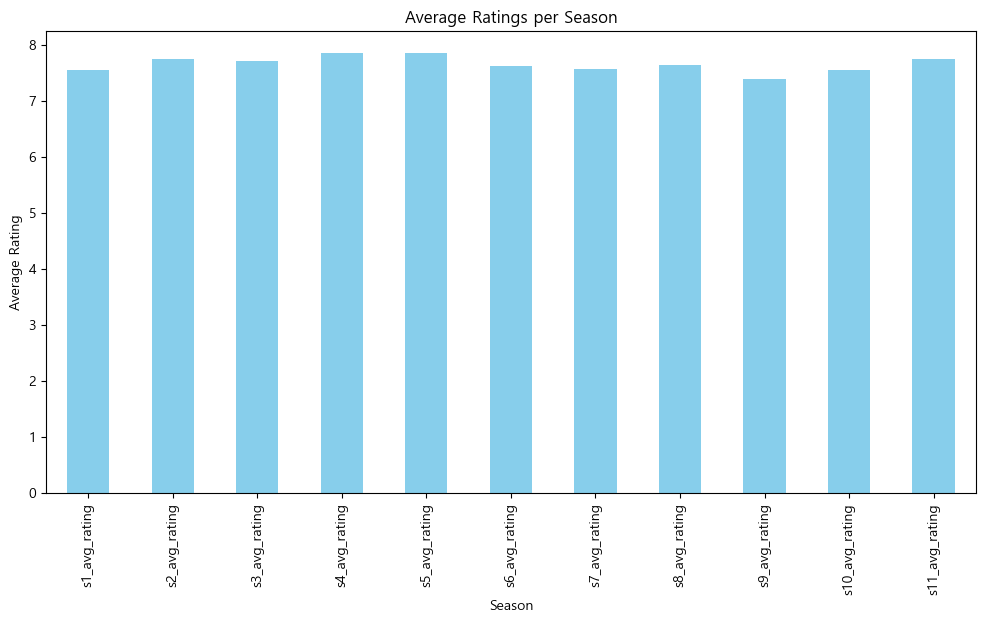

In [8]:
# 시즌별 평균 평점 비교
avg_rating_columns = [col for col in df.columns if 'avg_rating' in col]
avg_ratings = df[avg_rating_columns].mean()

plt.figure(figsize=(12, 6))
avg_ratings.plot(kind='bar', color='skyblue')
plt.title('Average Ratings per Season')
plt.xlabel('Season')
plt.ylabel('Average Rating')
plt.show()

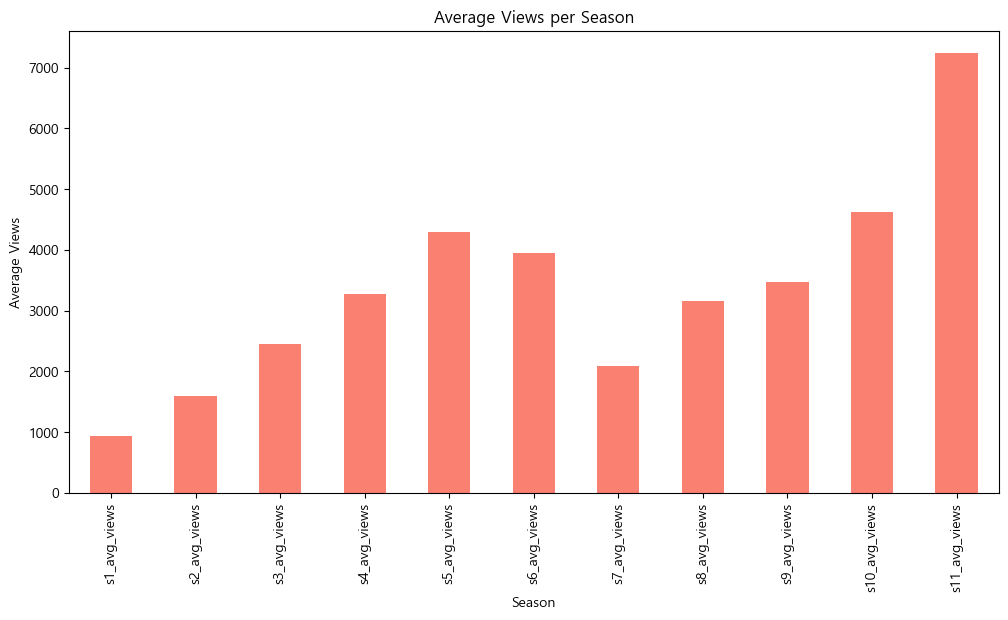

In [9]:
# 시즌별 평균 조회수 비교
avg_views_columns = [col for col in df.columns if 'avg_views' in col]
avg_views = df[avg_views_columns].mean()

plt.figure(figsize=(12, 6))
avg_views.plot(kind='bar', color='salmon')
plt.title('Average Views per Season')
plt.xlabel('Season')
plt.ylabel('Average Views')
plt.show()

- s11가 유난히 큰값처럼 보임. 인기가 좋은 워킹데드의 마지막 시즌이라 유난히 사람이 많은것인가? -> 아니다
- 워킹데드 시즌11까지 평균8000명의 평점매긴사람 + 블랙리스트 평균1500명의 평점매긴사람

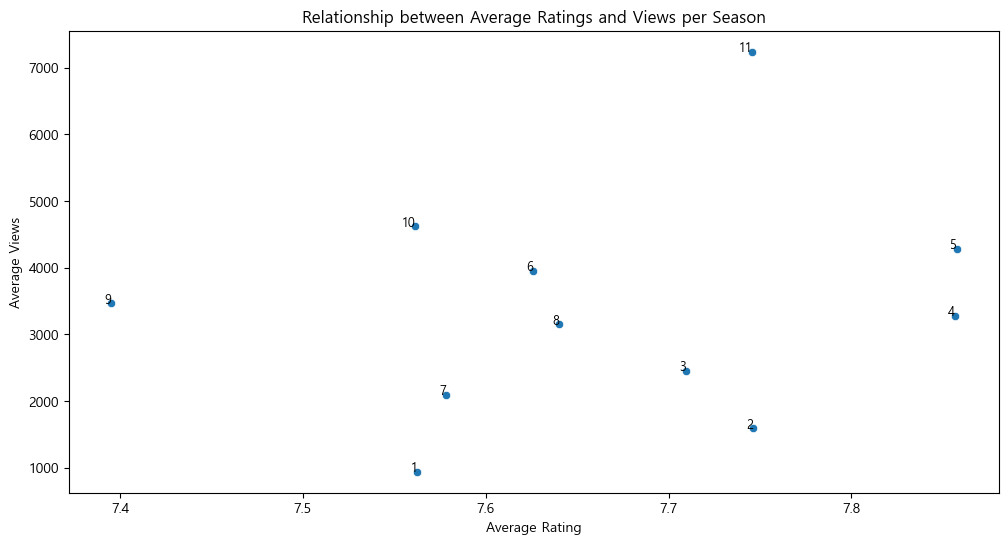

In [10]:
# 시즌별 평균 평점과 조회수 데이터프레임 생성
avg_ratings_views = pd.DataFrame({
    'Season': range(1, 12),
    'Average Rating': [df[f's{s}_avg_rating'].mean() for s in range(1, 12)],
    'Average Views': [df[f's{s}_avg_views'].mean() for s in range(1, 12)]
})

# 시각화
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Average Rating', y='Average Views', data=avg_ratings_views)

# 각 점에 시즌 번호를 레이블로 추가
for i in range(len(avg_ratings_views)):
    plt.text(avg_ratings_views['Average Rating'][i], avg_ratings_views['Average Views'][i], avg_ratings_views['Season'][i], fontsize=9, ha='right')

plt.title('Relationship between Average Ratings and Views per Season')
plt.xlabel('Average Rating')
plt.ylabel('Average Views')
plt.show()

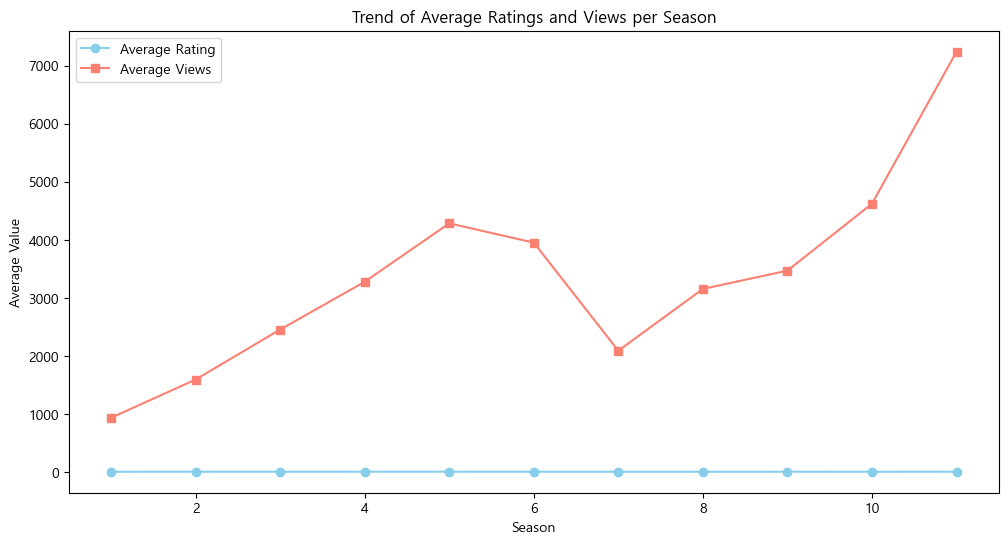

In [11]:
# 시즌별 평점과 조회수의 추세
seasons = range(1, len(avg_ratings) + 1)

plt.figure(figsize=(12, 6))
plt.plot(seasons, avg_ratings.values, marker='o', color='skyblue', label='Average Rating')
plt.plot(seasons, avg_views.values, marker='s', color='salmon', label='Average Views')
plt.title('Trend of Average Ratings and Views per Season')
plt.xlabel('Season')
plt.ylabel('Average Value')
plt.legend()
plt.show()

In [12]:
# 시즌 1의 평균 평점이 높은 10개 작품 (시즌 2가 없는 작품)
top_10_no_season_2 = df[df['season_2'].isna()].nlargest(10, 's1_avg_rating')

# 시즌 1의 평균 평점이 높은 10개 작품 (시즌 2가 있는 작품)
top_10_with_season_2 = df[df['season_2'].notna()].nlargest(10, 's1_avg_rating')

# 두 그룹을 비교하는 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Title': top_10_no_season_2['korean_title'].tolist() + top_10_with_season_2['korean_title'].tolist(),
    'Season 1 Avg Rating': top_10_no_season_2['s1_avg_rating'].tolist() + top_10_with_season_2['s1_avg_rating'].tolist(),
    'Has Season 2': ['No'] * 10 + ['Yes'] * 10
})

print(comparison_df)

                Title  Season 1 Avg Rating Has Season 2
0             페르마의 요리             9.690000           No
1               멜랑꼴리아             9.543750           No
2     여생 청다지교: 사랑의 서약             9.487500           No
3                 산하령             9.310811           No
4            아날로그 스쿼드             9.300000           No
5             징크스의 연인             9.243750           No
6                  봄밤             9.237500           No
7              니미소시흔미             9.103226           No
8                 옥골요             9.102500           No
9   내일 지구가 망해버렸으면 좋겠어             9.083333           No
10            드래곤 사쿠라             8.836364          Yes
11            기묘한 이야기             8.787500          Yes
12              하트스토퍼             8.787500          Yes
13            아스달 연대기             8.766667          Yes
14                 환혼             8.740000          Yes
15                덱스터             8.733333          Yes
16            빨간 머리 앤             8.700000      

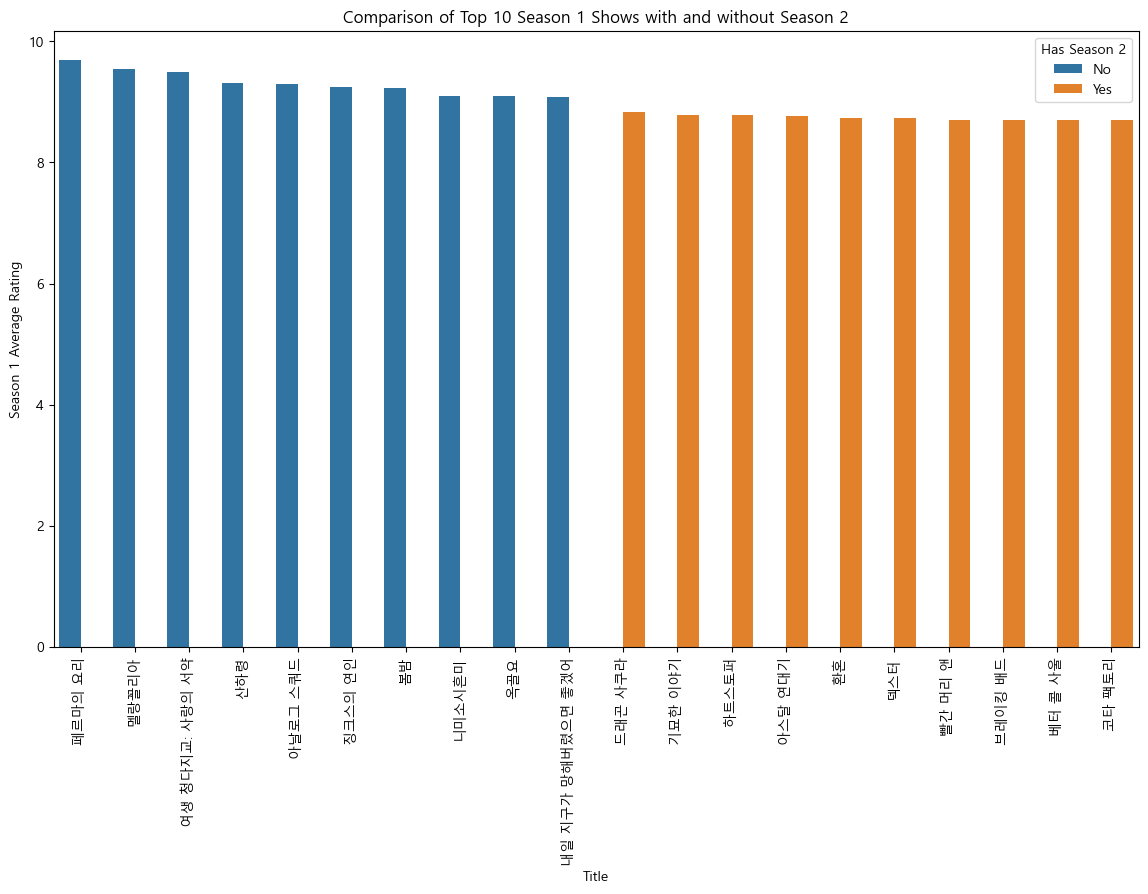

In [13]:
# 시각화
plt.figure(figsize=(14, 8))
sns.barplot(x='Title', y='Season 1 Avg Rating', hue='Has Season 2', data=comparison_df)
plt.title('Comparison of Top 10 Season 1 Shows with and without Season 2')
plt.xticks(rotation=90)
plt.xlabel('Title')
plt.ylabel('Season 1 Average Rating')
plt.legend(title='Has Season 2')
plt.show()

## 배급사, 제작사

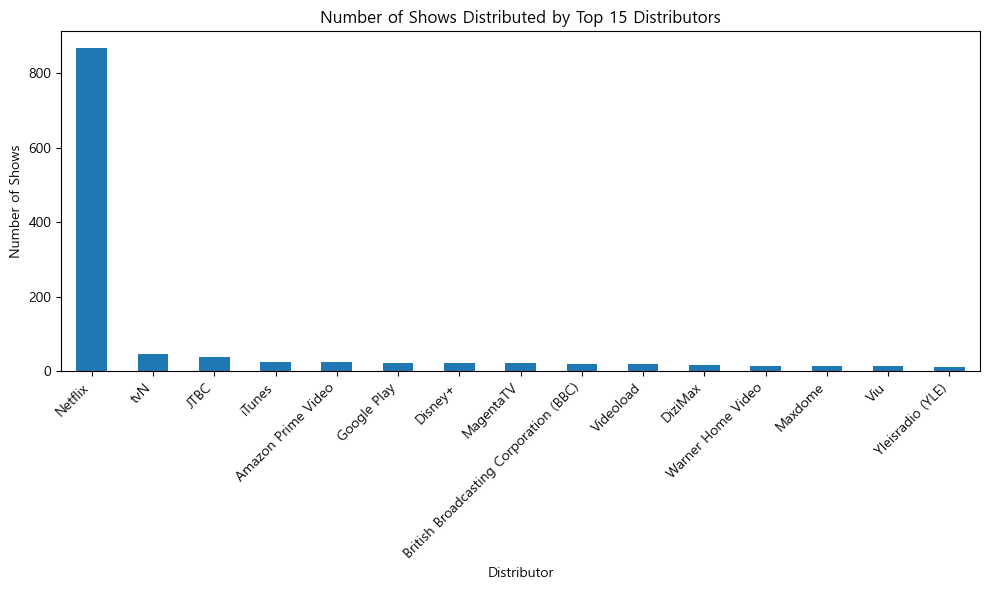

In [14]:
# 데이터프레임에서 배급사 정보 가져오기 (리스트 형태)
distributors = df['distributor'].explode().dropna()

# 각 배급사별 작품 수 계산
distributor_counts = distributors.value_counts()

# 탑 15개 배급사 선택
top_15_distributors = distributor_counts.head(15)

# 시각화
plt.figure(figsize=(10, 6))
top_15_distributors.plot(kind='bar')
plt.title('Number of Shows Distributed by Top 15 Distributors')
plt.xlabel('Distributor')
plt.ylabel('Number of Shows')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

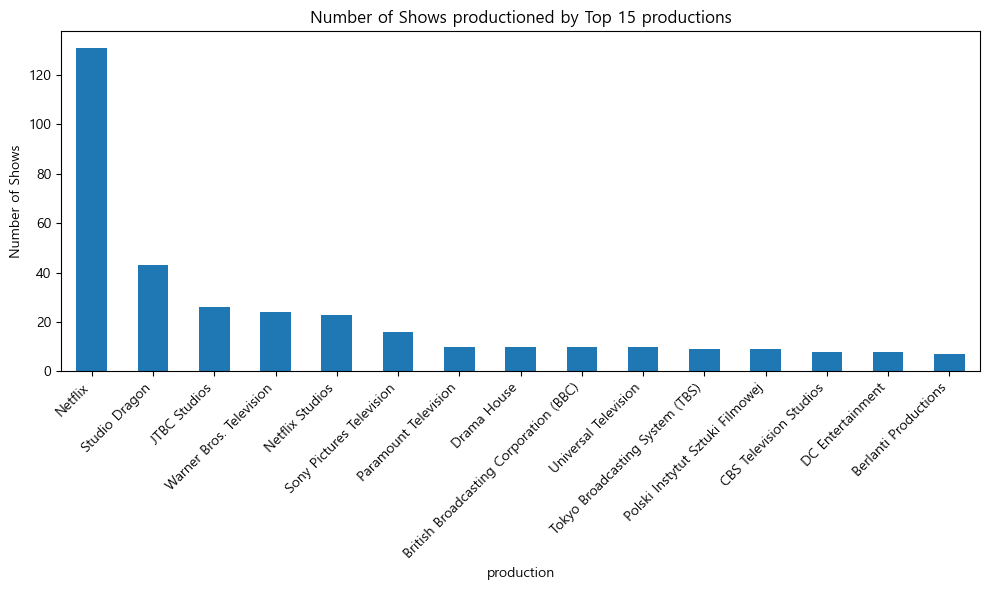

In [15]:
# 데이터프레임에서 제작사 정보 가져오기 (리스트 형태)
productions = df['production'].explode().dropna()

# 각 제작사별 작품 수 계산
production_counts = productions.value_counts()

# 탑 15개 제작사 선택
top_15_productions = production_counts.head(15)

# 시각화
plt.figure(figsize=(10, 6))
top_15_productions.plot(kind='bar')
plt.title('Number of Shows productioned by Top 15 productions')
plt.xlabel('production')
plt.ylabel('Number of Shows')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 시계열 EDA 시도

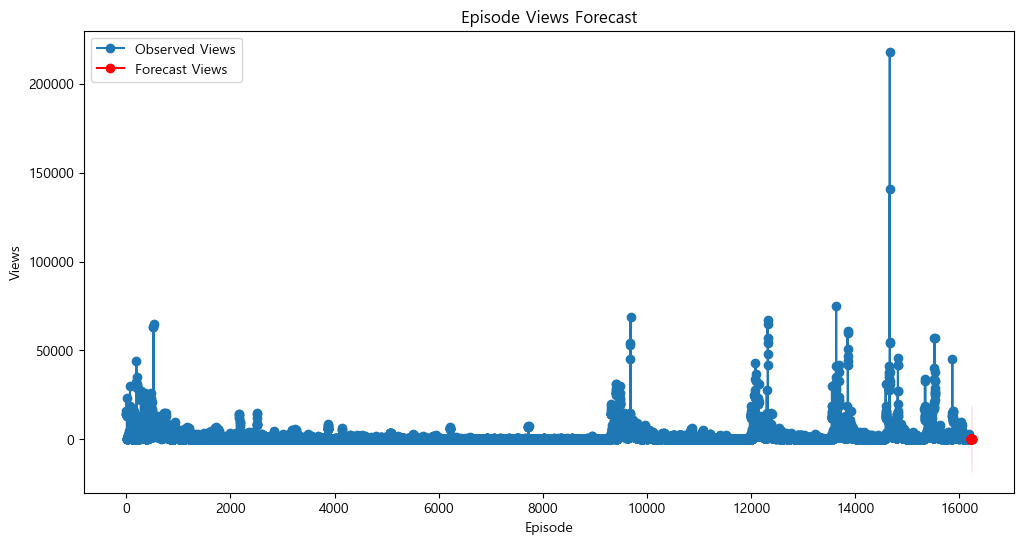

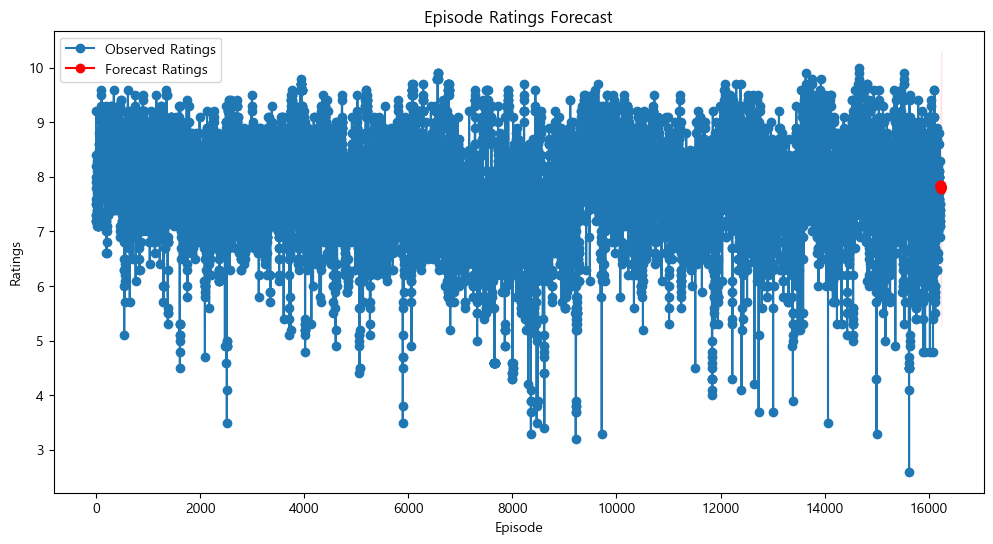

In [16]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

num_seasons = 7
seasons = [f'season_{i}' for i in range(1, num_seasons + 1)]

# 모든 에피소드의 views와 ratings 값을 각각의 리스트로 수집
all_views = []
all_ratings = []
for season in seasons:
    for index, row in df.iterrows():
        if season in row and row[season]:
            all_views.extend([ep[1] for ep in row[season].values()])
            all_ratings.extend([ep[0] for ep in row[season].values()])

# views 시계열 데이터프레임 생성
views_series = pd.Series(all_views, name='views')
# ratings 시계열 데이터프레임 생성
ratings_series = pd.Series(all_ratings, name='ratings')

# 시계열 모델 학습 및 예측 (views)
model_views = SARIMAX(views_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_views = model_views.fit()

# 시계열 모델 학습 및 예측 (ratings)
model_ratings = SARIMAX(ratings_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_ratings = model_ratings.fit()

# 미래 20 에피소드에 대한 예측 (views)
forecast_views = results_views.get_forecast(steps=20)
forecast_views_index = range(len(views_series) + 1, len(views_series) + 21)
forecast_views_series = pd.Series(forecast_views.predicted_mean, index=forecast_views_index, name='forecast_views')

# 미래 20 에피소드에 대한 예측 (ratings)
forecast_ratings = results_ratings.get_forecast(steps=20)
forecast_ratings_index = range(len(ratings_series) + 1, len(ratings_series) + 21)
forecast_ratings_series = pd.Series(forecast_ratings.predicted_mean, index=forecast_ratings_index, name='forecast_ratings')

# 시계열 데이터 시각화 (views)
plt.figure(figsize=(12, 6))
plt.plot(views_series, marker='o', linestyle='-', label='Observed Views')
plt.plot(forecast_views_series, marker='o', linestyle='-', color='red', label='Forecast Views')
plt.fill_between(forecast_views_index, forecast_views.conf_int()['lower views'], forecast_views.conf_int()['upper views'], color='pink', alpha=0.3)
plt.title('Episode Views Forecast')
plt.xlabel('Episode')
plt.ylabel('Views')
plt.legend()
plt.show()

# 시계열 데이터 시각화 (ratings)
plt.figure(figsize=(12, 6))
plt.plot(ratings_series, marker='o', linestyle='-', label='Observed Ratings')
plt.plot(forecast_ratings_series, marker='o', linestyle='-', color='red', label='Forecast Ratings')
plt.fill_between(forecast_ratings_index, forecast_ratings.conf_int()['lower ratings'], forecast_ratings.conf_int()['upper ratings'], color='pink', alpha=0.3)
plt.title('Episode Ratings Forecast')
plt.xlabel('Episode')
plt.ylabel('Ratings')
plt.legend()
plt.show()

c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


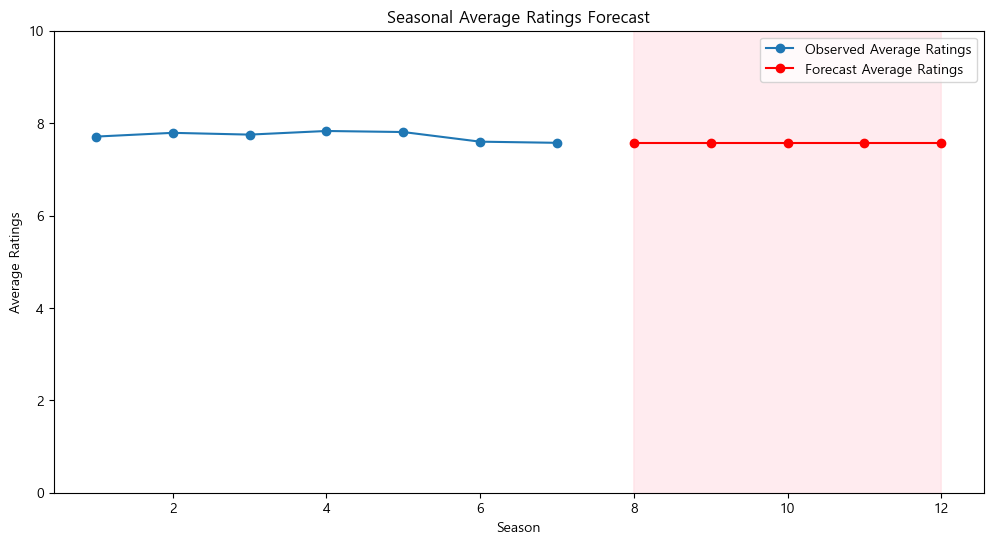

In [17]:
num_seasons = 7
seasons = [f'season_{i}' for i in range(1, num_seasons + 1)]

# 각 시즌의 평균 ratings 값을 하나의 리스트로 수집
average_ratings = []
for season in seasons:
    season_ratings = []
    for index, row in df.iterrows():
        if season in row and row[season]:
            season_ratings.extend([ep[0] for ep in row[season].values()])
    if season_ratings:
        average_ratings.append(np.mean(season_ratings))

# 평균 ratings 시계열 데이터프레임 생성
ratings_series = pd.Series(average_ratings, index=range(1, num_seasons + 1), name='average_ratings')

# 시계열 모델 학습 및 예측
model_ratings = SARIMAX(ratings_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_ratings = model_ratings.fit()

# 미래 5 시즌에 대한 예측
forecast_ratings = results_ratings.get_forecast(steps=5)
forecast_ratings_index = range(num_seasons + 1, num_seasons + 6)
forecast_ratings_series = pd.Series(forecast_ratings.predicted_mean, index=forecast_ratings_index, name='forecast_ratings')

# 시계열 데이터 시각화 (ratings)
plt.figure(figsize=(12, 6))
plt.plot(ratings_series, marker='o', linestyle='-', label='Observed Average Ratings')
plt.plot(forecast_ratings_series, marker='o', linestyle='-', color='red', label='Forecast Average Ratings')
plt.fill_between(forecast_ratings_index, forecast_ratings.conf_int()['lower average_ratings'], forecast_ratings.conf_int()['upper average_ratings'], color='pink', alpha=0.3)
plt.ylim(0, 10)  # y축 범위를 0에서 10으로 설정
plt.title('Seasonal Average Ratings Forecast')
plt.xlabel('Season')
plt.ylabel('Average Ratings')
plt.legend()
plt.show()

In [18]:
# 'date_of_first' 컬럼 추가
df['date_of_first'] = [next(iter(data_dict.values()))[2] for data_dict in df['season_1']]
# 'date_of_second' 컬럼 추가
df['date_of_second'] = [list(data_dict.values())[1][2] if len(data_dict) > 1 else None for data_dict in df['season_1']]
# 'date_of_last' 컬럼 추가
df['date_of_last'] = [list(data_dict.values())[-1][2] for data_dict in df['season_1']]
# 'term' 컬럼 추가
df['term'] = df.apply(lambda row: 0 if row['date_of_last'] == row['date_of_first'] else (1 if row['date_of_first'] == row['date_of_second'] else 2), axis=1)

# 결과 확인
print(df[['season_1', 'date_of_first', 'date_of_second', 'date_of_last', 'term']])

                                                     season_1  \
Unnamed: 0                                                      
0           {'S1.E1': [8.2, 16000, 'Fri, Sep 17, 2021'], '...   
1           {'S1.E1': [7.3, 224, 'Sun, Nov 3, 2019'], 'S1....   
2           {'S1.E1': [7.4, 62, 'Thu, Apr 30, 2020'], 'S1....   
3           {'S1.E1': [7.9, 2500, 'Fri, Jun 4, 2021'], 'S1...   
4           {'S1.E1': [7.1, 1100, 'Fri, Dec 18, 2020'], 'S...   
...                                                       ...   
900         {'S1.E1': [5.6, 322, 'Fri, Jun 14, 2019'], 'S1...   
901         {'S1.E1': [7.6, 148, 'Fri, Apr 14, 2017'], 'S1...   
902         {'S1.E1': [5.8, 60, 'Fri, Apr 17, 2020'], 'S1....   
903         {'S1.E1': [8.0, 44, 'Thu, Aug 8, 2019'], 'S1.E...   
904         {'S1.E1': [6.5, 225, 'Tue, Jun 15, 2021'], 'S1...   

                date_of_first     date_of_second       date_of_last  term  
Unnamed: 0                                                                 
0 

In [19]:
# 시청 지속율(관심유지도) 계산 함수
def calculate_retention_rate(season_data):
    episode_views = [ep[1] for ep in season_data.values() if isinstance(ep, (list, tuple))]
    if len(episode_views) > 1:
        initial_viewers = episode_views[0]
        final_viewers = episode_views[-1]
        retention_rate = (final_viewers / initial_viewers) * 100
    else:
        retention_rate = 100  # If there's only one episode, retention is 100%
    return retention_rate

# 시즌 1의 시청 지속율 계산
df['s1_retention_rate'] = df['season_1'].apply(calculate_retention_rate)

In [20]:
df = df[['korean_title','english_title','runtime','genre','age_rating','production_country','s1_avg_rating','s1_avg_views','s1_retention_rate','term']]

## PCA 시도(범주형 데이터 인코딩 후 시즌별 정보 PCA)
- production_country 제작 국가인 경우 일단 첫 나라만 선택 후 TargetEncoder
- genre: MultiLabel

In [21]:
# production_country 컬럼의 데이터를 처리하는 함수 정의
def process_countries(countries):
    # 쉼표를 기준으로 분리하고 첫 번째 나라 선택
    countries_list = countries.split(',')
    first_country = countries_list[0].strip()
    return first_country

# apply 함수를 사용하여 모든 행에 적용
df['production_country'] = df['production_country'].apply(process_countries)

In [22]:
import category_encoders as ce

# TargetEncoder 객체 생성 및 fit_transform으로 변환 (count 사용)
target_encoder = ce.TargetEncoder(cols=['production_country'], handle_unknown='count')
df_im_encoded = target_encoder.fit_transform(df['production_country'], df.index)

# 인코딩된 값을 기존 데이터프레임에 추가
df['production_country_encoded'] = df_im_encoded

print(df[['production_country','production_country_encoded']])

           production_country  production_country_encoded
Unnamed: 0                                               
0                        대한민국                  417.181824
1                         벨기에                  443.500502
2                          대만                  509.258276
3                          미국                  299.276018
4                        대한민국                  417.181824
...                       ...                         ...
900                        인도                  659.064601
901                        일본                  513.131229
902                        인도                  659.064601
903                       레바논                  510.678922
904                       스페인                  530.323066

[905 rows x 2 columns]


In [23]:
del df['production_country']

In [24]:
#원핫인코딩
df['genre'] = df['genre'].apply(lambda x: x.split(', '))
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df['genre'])
genre_encoded_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)
df_im = pd.concat([genre_encoded_df, df.drop(columns=['genre'])], axis=1)

In [25]:
df_im.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905 entries, 0 to 904
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Made in Europe              905 non-null    int32  
 1   SF                          905 non-null    int32  
 2   가족                          905 non-null    int32  
 3   공포                          905 non-null    int32  
 4   드라마                         905 non-null    int32  
 5   로맨스                         905 non-null    int32  
 6   범죄                          905 non-null    int32  
 7   서부                          905 non-null    int32  
 8   스릴러                         905 non-null    int32  
 9   스포츠                         905 non-null    int32  
 10  액션                          905 non-null    int32  
 11  역사                          905 non-null    int32  
 12  음악                          905 non-null    int32  
 13  전쟁                          905 non

In [26]:
numeric_df = df_im.select_dtypes(include=['int32', 'uint8'])  # 'uint8'은 원핫 인코딩된 컬럼의 데이터 타입

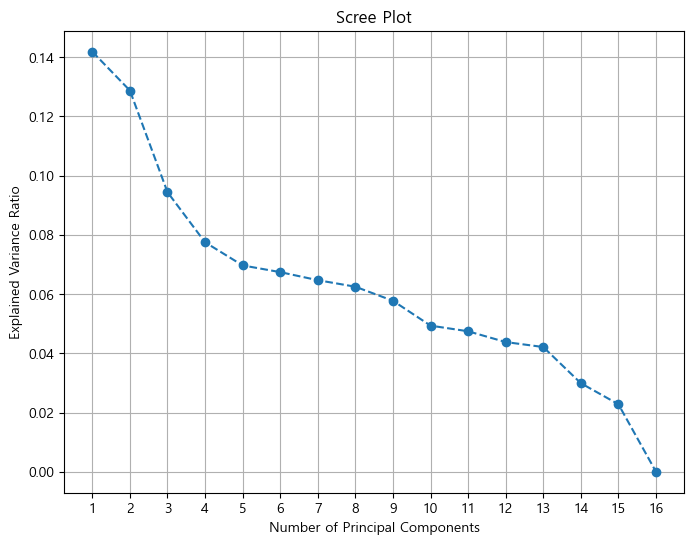

In [27]:
# 데이터 표준화
scaler = StandardScaler()
numeric_df_scaled = scaler.fit_transform(numeric_df)

# PCA 수행
pca = PCA()
pca.fit(numeric_df_scaled)

# Scree Plot 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(True)
plt.show()

In [28]:
# 설명된 분산 비율 출력
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio for each principal component:")
for i, var_ratio in enumerate(explained_variance_ratio, start=1):
    print(f"Principal Component {i}: {var_ratio:.4f}")

Explained variance ratio for each principal component:
Principal Component 1: 0.1419
Principal Component 2: 0.1288
Principal Component 3: 0.0944
Principal Component 4: 0.0775
Principal Component 5: 0.0697
Principal Component 6: 0.0674
Principal Component 7: 0.0647
Principal Component 8: 0.0625
Principal Component 9: 0.0577
Principal Component 10: 0.0493
Principal Component 11: 0.0474
Principal Component 12: 0.0438
Principal Component 13: 0.0421
Principal Component 14: 0.0299
Principal Component 15: 0.0228
Principal Component 16: 0.0000


- 다시 PCA하는건 의미 없겠음

## IMDb 군집화

In [29]:
df_im['age_rating'] = df_im['age_rating'].replace('ALL', 0).astype(int)

In [30]:
# 이 컬럼은 여기서 사용하지 않을 예정이라 잠시 뺌
del df_im['korean_title']
del df_im['english_title']

In [31]:
# 데이터 표준화
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_im)

# NumPy 배열을 데이터프레임으로 변환
df_scaled_df = pd.DataFrame(df_scaled, columns=df_im.columns)

In [32]:
df_scaled_df.head()

,Made in Europe,SF,가족,공포,드라마,로맨스,범죄,서부,스릴러,스포츠,...,전쟁,코미디,판타지,runtime,age_rating,s1_avg_rating,s1_avg_views,s1_retention_rate,term,production_country_encoded
0,-0.150329,-0.501726,-0.209354,-0.300602,0.0,-0.563313,-0.645194,-0.074536,1.250496,-0.115922,...,-0.181948,-0.686691,-0.404029,0.549457,0.761370,0.591974,4.424240,0.506751,-0.885018,-0.148134
1,-0.150329,-0.501726,-0.209354,-0.300602,0.0,-0.563313,-0.645194,-0.074536,1.250496,-0.115922,...,-0.181948,-0.686691,-0.404029,0.476886,0.761370,-0.346513,-0.239082,0.177364,1.181927,0.128248
2,-0.150329,-0.501726,-0.209354,-0.300602,0.0,-0.563313,1.549921,-0.074536,1.250496,-0.115922,...,-0.181948,-0.686691,-0.404029,0.912314,0.761370,0.263870,-0.279981,0.553726,-0.885018,0.818796
3,-0.150329,1.993120,-0.209354,-0.300602,0.0,-0.563313,-0.645194,-0.074536,-0.799683,-0.115922,...,-0.181948,-0.686691,2.475073,0.331743,-0.611903,0.461832,0.321216,0.215503,-0.885018,-1.386308
4,-0.150329,1.993120,-0.209354,3.326660,0.0,-0.563313,1.549921,-0.074536,1.250496,-0.115922,...,-0.181948,-0.686691,2.475073,0.912314,0.761370,-0.320118,-0.027381,-0.010434,-0.885018,-0.148134


In [33]:
df_scaled_df = df_scaled_df[['runtime','age_rating','s1_avg_rating','s1_avg_views','s1_retention_rate','term','production_country_encoded']]

In [34]:
# 군집수에 따른 실루엣계수를 담을 리스트
silhouette_scores = []

# 2~10까지 군집수를 변화시키며 실루엣계수를 계산
for n_clusters in range(2, 16):
    # KMeans 군집화 수행
    kmeans = KMeans(n_clusters=n_clusters, random_state=13)
    kmeans.fit(df_scaled_df)

    # 실루엣계수 계산
    silhouette_score_ = silhouette_score(df_scaled_df, kmeans.labels_)
    silhouette_scores.append(silhouette_score_)

c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception in thread Thread-18:
Traceback (most recent call last):
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\subprocess.py", line 1386, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb1 in position 24: invalid start byte
c:\Users\rbfl7\miniconda3\envs

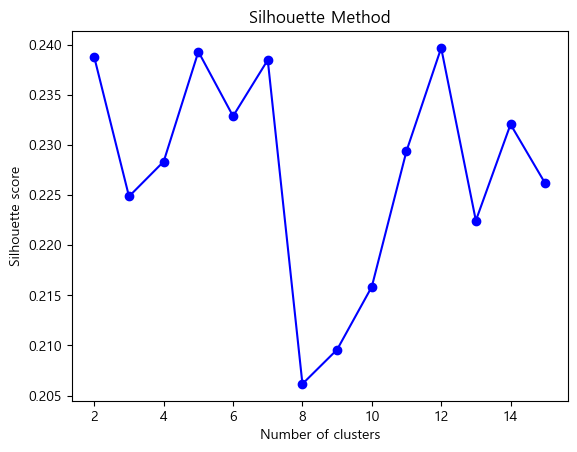

In [35]:
# 군집수에 따른 실루엣계수 그래프 그리기
plt.plot(range(2, 16), silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.show()

In [36]:
from sklearn.cluster import KMeans
import plotly.graph_objects as go

# KMeans 군집화
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(df_scaled_df)

# 군집 레이블을 기준으로 데이터프레임에 추가
df_scaled_df['cluster'] = cluster_labels

# 클러스터별로 데이터 분리
clusters = []
for i in range(5):
    clusters.append(df_scaled_df[df_scaled_df['cluster'] == i])

# Plotly를 사용하여 시각화
fig = go.Figure()

# 각 군집에 대한 산점도 추가
# 12개의 고유한 색상을 설정
colors = [
    'blue', 'red', 'green', 'orange', 'purple'
]

for i, cluster in enumerate(clusters):
    fig.add_trace(go.Scatter(
        x=cluster['s1_avg_rating'], 
        y=cluster['s1_avg_views'],
        mode='markers', 
        marker=dict(color=colors[i]), 
        name=f'Cluster {i}'
    ))

fig.show()

c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [37]:
import plotly.graph_objects as go

# Create a list of variable names
variable_names = ['runtime', 'age_rating', 's1_avg_rating', 's1_avg_views', 's1_retention_rate', 'term', 'production_country_encoded']

# Define colors for each cluster
colors = ['blue', 'red', 'green', 'orange', 'purple']

# Loop through each variable and create a scatter plot for each cluster
for variable in variable_names:
    # Create an empty figure
    fig = go.Figure()

    # Loop through each cluster
    for i in range(5):  # 클러스터 개수에 맞게 수정 (여기서는 5개의 클러스터를 가정)
        # Filter data for the current cluster
        cluster_data = df_scaled_df[df_scaled_df['cluster'] == i]

        # Add scatter trace for the current cluster and variable
        fig.add_trace(go.Scatter(
            x=cluster_data[variable],
            y=cluster_data['s1_avg_rating'],
            mode='markers',
            marker=dict(color=colors[i]),
            name=f'Cluster {i}'
        ))

    # Set layout for the plot
    fig.update_layout(
        title=f"Scatter Plot of {variable} vs s1_avg_rating",
        xaxis=dict(title=variable),
        yaxis=dict(title='s1_avg_rating')
    )

    # Show plot
    fig.show()


---

## Watcha data 와 IMDb data 비교

In [38]:
df_im['korean_title'] = df['korean_title']

In [39]:
# 엑셀 파일을 읽어옵니다.
df_wat = pd.read_excel('../data/file/watcha.xlsx', index_col=0)
df_wat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 905 entries, 0 to 904
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   korean_title        905 non-null    object 
 1   english_title       905 non-null    object 
 2   year                905 non-null    int64  
 3   total_season_num    905 non-null    int64  
 4   production_country  905 non-null    object 
 5   watcha_name         905 non-null    object 
 6   season_1            905 non-null    object 
 7   season_2            266 non-null    object 
 8   season_3            136 non-null    object 
 9   season_4            79 non-null     object 
 10  season_5            49 non-null     object 
 11  season_6            35 non-null     object 
 12  season_7            21 non-null     object 
 13  season_8            8 non-null      object 
 14  season_9            4 non-null      object 
 15  season_10           2 non-null      object 
 16  season_11    

In [40]:
df_wat = df_wat[['korean_title','english_title','year','season_1']]

In [41]:
# 문자열을 리스트로 변환하는 함수
def parseStringToList(string):
    if pd.isna(string):  # NaN 값인 경우 빈 리스트 반환
        return None
    # 문자열에서 각 요소를 구분하는 쉼표로 분할
    elements = string.split(', ')
    # 각 요소에서 양쪽의 작은따옴표 제거
    elements = [element.strip("['").strip("']") for element in elements]
    return elements

df_wat['season_1'] = df_wat['season_1'].apply(parseStringToList)

In [42]:
# 'season_1' 열의 첫 번째 값: 평점
df_wat['w_s1_rate'] = df_wat['season_1'].apply(lambda x: float(x[0]))

# 'season_1' 열의 두 번째 값: 평점 참여 인원 수
df_wat['w_s1_views'] = df_wat['season_1'].apply(lambda x: int(x[1]))

# reviews수
df_wat['w_s1_reviews'] = df_wat['season_1'].apply(lambda x: int(x[2]))

In [43]:
df_wat

,korean_title,english_title,year,season_1,w_s1_rate,w_s1_views,w_s1_reviews
0,오징어 게임,Squid Game,2021,"[3.3, 95000, 7500]",3.3,95000,7500
1,12인의 심판자,The Twelve,2019,"[2.8, 55, 6]",2.8,55,6
2,희생자 게임,The Victims' Game,2020,"[3.2, 290, 30]",3.2,290,30
3,스위트 투스: 사슴뿔을 가진 소년,Sweet Tooth,2021,"[3.6, 2860, 250]",3.6,2860,250
4,스위트홈,Sweet Home,2020,"[3.5, 64000, 4000]",3.5,64000,4000
...,...,...,...,...,...,...,...
900,레일라,Leila,2019,"[3.2, 27, 3]",3.2,27,3
901,100만 엔의 여인들,Million Yen Women,2017,"[3.0, 718, 100]",3.0,718,100
902,킬러 코미디언,Hasmukh,2020,"[1.6, 4, 0]",1.6,4,0
903,달러,Dollar,2019,"[0.7, 3, 1]",0.7,3,1


In [46]:
df = pd.merge(df_im, df_wat, on=['korean_title'], how='left')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


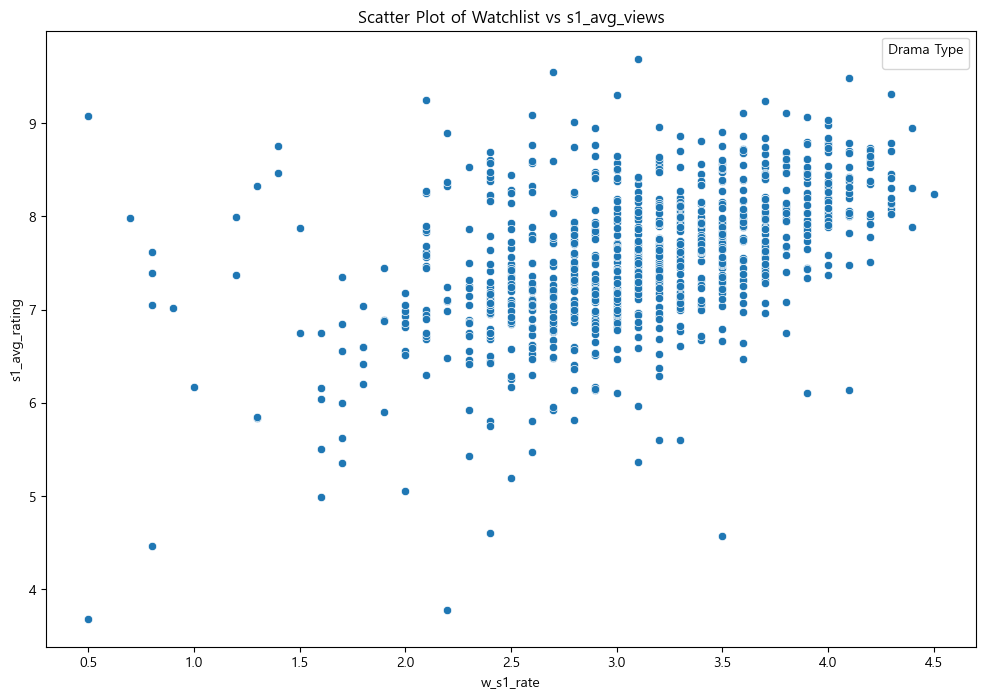

In [47]:
# 그래프 생성
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='w_s1_rate', y='s1_avg_rating')
plt.title('Scatter Plot of Watchlist vs s1_avg_views')
plt.xlabel('w_s1_rate')
plt.ylabel('s1_avg_rating')
plt.legend(title='Drama Type')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


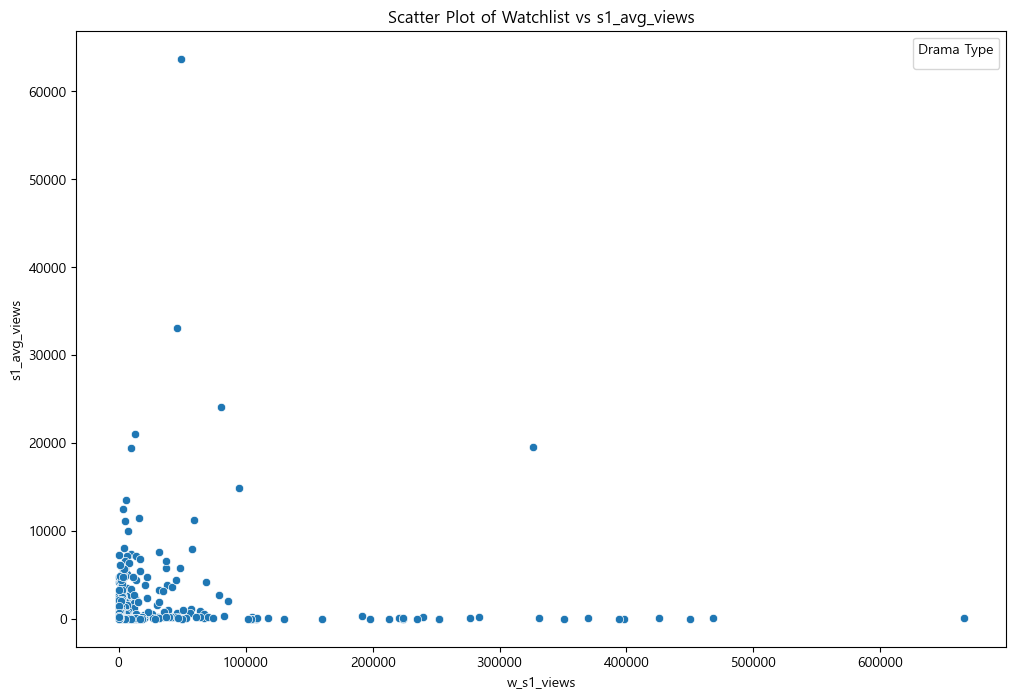

In [48]:
# 그래프 생성
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='w_s1_views', y='s1_avg_views')
plt.title('Scatter Plot of Watchlist vs s1_avg_views')
plt.xlabel('w_s1_views')
plt.ylabel('s1_avg_views')
plt.legend(title='Drama Type')
plt.show()

In [49]:
df[df['s1_avg_views'] >= 50000]

,Made in Europe,SF,가족,공포,드라마,로맨스,범죄,서부,스릴러,스포츠,...,s1_retention_rate,term,production_country_encoded,korean_title,english_title,year,season_1,w_s1_rate,w_s1_views,w_s1_reviews
46,0,1,0,0,1,0,1,0,1,0,...,103.174603,2,379.932063,블랙 미러,Black Mirror,2011,"[4.0, 49000, 1500]",4.0,49000,1500


In [50]:
df[df['w_s1_views'] >= 500000]

,Made in Europe,SF,가족,공포,드라마,로맨스,범죄,서부,스릴러,스포츠,...,s1_retention_rate,term,production_country_encoded,korean_title,english_title,year,season_1,w_s1_rate,w_s1_views,w_s1_reviews
609,0,0,0,0,1,0,0,0,0,0,...,58.75,2,417.181824,SKY 캐슬,SKY Castle,2018,"[4.2, 666000, 4000]",4.2,666000,4000
